In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [2]:
df = pd.read_csv("/kaggle/input/data-sensor/full_data.csv")
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Unnamed: 0,result,table,_start,_stop,_time,_value,_field,_measurement
0,NaN,NaN,0,2025-04-30T07:26:51.3787325Z,2025-05-30T07:26:51.3787325Z,2025-05-13T10:37:33Z,31.0,gas,esp32-data-sensor
1,NaN,NaN,0,2025-04-30T07:26:51.3787325Z,2025-05-30T07:26:51.3787325Z,2025-05-13T10:37:38Z,24.0,gas,esp32-data-sensor
2,NaN,NaN,0,2025-04-30T07:26:51.3787325Z,2025-05-30T07:26:51.3787325Z,2025-05-13T10:37:43Z,31.0,gas,esp32-data-sensor
3,NaN,NaN,0,2025-04-30T07:26:51.3787325Z,2025-05-30T07:26:51.3787325Z,2025-05-13T10:37:48Z,22.0,gas,esp32-data-sensor
4,NaN,NaN,0,2025-04-30T07:26:51.3787325Z,2025-05-30T07:26:51.3787325Z,2025-05-13T10:37:53Z,31.0,gas,esp32-data-sensor
...,...,...,...,...,...,...,...,...,...
50038,NaN,NaN,2,2025-04-30T07:26:51.3787325Z,2025-05-30T07:26:51.3787325Z,2025-05-30T07:26:02Z,30.5,temperature,esp32-data-sensor
50039,NaN,NaN,2,2025-04-30T07:26:51.3787325Z,2025-05-30T07:26:51.3787325Z,2025-05-30T07:26:12Z,30.0,temperature,esp32-data-sensor
50040,NaN,NaN,2,2025-04-30T07:26:51.3787325Z,2025-05-30T07:26:51.3787325Z,2025-05-30T07:26:22Z,30.2,temperature,esp32-data-sensor
50041,NaN,NaN,2,2025-04-30T07:26:51.3787325Z,2025-05-30T07:26:51.3787325Z,2025-05-30T07:26:32Z,30.2,temperature,esp32-data-sensor


In [3]:
df = df.drop(['Unnamed: 0', 'result', 'table', '_measurement', '_start', '_stop'], axis = 1)
df

,_time,_value,_field
0,2025-05-13T10:37:33Z,31.0,gas
1,2025-05-13T10:37:38Z,24.0,gas
2,2025-05-13T10:37:43Z,31.0,gas
3,2025-05-13T10:37:48Z,22.0,gas
4,2025-05-13T10:37:53Z,31.0,gas
...,...,...,...
50038,2025-05-30T07:26:02Z,30.5,temperature
50039,2025-05-30T07:26:12Z,30.0,temperature
50040,2025-05-30T07:26:22Z,30.2,temperature
50041,2025-05-30T07:26:32Z,30.2,temperature


In [4]:
df.info()          # xem kiểu dữ liệu

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50043 entries, 0 to 50042
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   _time   50043 non-null  object 
 1   _value  50043 non-null  float64
 2   _field  50043 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [5]:
df.isna().sum()    # đếm NaN

_time     0
_value    0
_field    0
dtype: int64

# Processing data

In [6]:
df_wide = (df
           .assign(_time=pd.to_datetime(df["_time"]))
           .pivot_table(index="_time",
                        columns="_field",
                        values="_value",
                        aggfunc="first")   # nếu trùng timestamp → lấy bản ghi đầu
           .sort_index())
df_wide.columns.name = None   # bỏ caption 'field'
df_wide

,gas,humidity,temperature
_time,,,
2025-05-13 10:37:33+00:00,31.0,69.0,31.7
2025-05-13 10:37:38+00:00,24.0,69.0,31.8
2025-05-13 10:37:43+00:00,31.0,69.0,31.8
2025-05-13 10:37:48+00:00,22.0,70.0,31.4
2025-05-13 10:37:53+00:00,31.0,69.0,31.7
...,...,...,...
2025-05-30 07:26:02+00:00,1.0,62.0,30.5
2025-05-30 07:26:12+00:00,25.0,62.0,30.0
2025-05-30 07:26:22+00:00,24.0,62.0,30.2


In [7]:
df_1s = (df_wide
         .resample("5s")   
         .ffill())

In [8]:
lags = range(0, 21)           # 0 = hiện tại, 1 = 1s trước, ..., 20 = 20s trước

lagged_frames = []
for lag in lags:
    shifted = df_1s.shift(lag)
    shifted.columns = [f"{col}_-{lag}s" for col in shifted.columns]
    lagged_frames.append(shifted)

X = pd.concat(lagged_frames, axis=1).dropna()  # bỏ hàng đầu tiên chưa đủ 20s lịch sử
X["timestamp"] = X.index                       # giữ lại time nếu muốn
X = X.reset_index(drop=True)

X


,gas_-0s,humidity_-0s,temperature_-0s,gas_-1s,humidity_-1s,temperature_-1s,gas_-2s,humidity_-2s,temperature_-2s,gas_-3s,...,gas_-18s,humidity_-18s,temperature_-18s,gas_-19s,humidity_-19s,temperature_-19s,gas_-20s,humidity_-20s,temperature_-20s,timestamp
0,32.0,70.0,31.4,24.0,70.0,31.3,31.0,69.0,31.6,24.0,...,31.0,69.0,31.8,24.0,69.0,31.8,31.0,69.0,31.7,2025-05-13 10:39:15+00:00
1,24.0,70.0,31.4,32.0,70.0,31.4,24.0,70.0,31.3,31.0,...,22.0,70.0,31.4,31.0,69.0,31.8,24.0,69.0,31.8,2025-05-13 10:39:20+00:00
2,31.0,70.0,31.2,24.0,70.0,31.4,32.0,70.0,31.4,24.0,...,31.0,69.0,31.7,22.0,70.0,31.4,31.0,69.0,31.8,2025-05-13 10:39:25+00:00
3,24.0,69.0,31.2,31.0,70.0,31.2,24.0,70.0,31.4,32.0,...,25.0,69.0,31.8,31.0,69.0,31.7,22.0,70.0,31.4,2025-05-13 10:39:30+00:00
4,31.0,69.0,31.1,24.0,69.0,31.2,31.0,70.0,31.2,24.0,...,31.0,69.0,31.9,25.0,69.0,31.8,31.0,69.0,31.7,2025-05-13 10:39:35+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291445,25.0,62.0,30.0,25.0,62.0,30.0,1.0,62.0,30.5,1.0,...,28.0,63.0,30.0,28.0,63.0,30.0,21.0,63.0,30.3,2025-05-30 07:26:20+00:00
291446,24.0,62.0,30.2,25.0,62.0,30.0,25.0,62.0,30.0,1.0,...,290.0,63.0,30.9,28.0,63.0,30.0,28.0,63.0,30.0,2025-05-30 07:26:25+00:00
291447,24.0,62.0,30.2,24.0,62.0,30.2,25.0,62.0,30.0,25.0,...,290.0,63.0,30.9,290.0,63.0,30.9,28.0,63.0,30.0,2025-05-30 07:26:30+00:00
291448,22.0,62.0,30.2,24.0,62.0,30.2,24.0,62.0,30.2,25.0,...,75.0,64.0,30.2,290.0,63.0,30.9,290.0,63.0,30.9,2025-05-30 07:26:35+00:00


# Labeling

In [9]:
temp_cols = [f"temperature_-{i}s" for i in range(0, 10)]   # t, t-1s, … t-9s
hum_cols  = [f"humidity_-{i}s"    for i in range(0, 10)]
gas_cols  = [f"gas_-{i}s"    for i in range(0, 10)]

# ➋ Đặt điều kiện: max T > 38 °C & min RH < 60 %
cond = (X[temp_cols].max(axis=1) > 36) & (X[hum_cols].min(axis=1) < 70) & (X[gas_cols].min(axis=1) > 20)

# ➌ Thêm nhãn
X["label"] = cond.astype(int)      # 1 = cháy, 0 = không cháy
X


,gas_-0s,humidity_-0s,temperature_-0s,gas_-1s,humidity_-1s,temperature_-1s,gas_-2s,humidity_-2s,temperature_-2s,gas_-3s,...,humidity_-18s,temperature_-18s,gas_-19s,humidity_-19s,temperature_-19s,gas_-20s,humidity_-20s,temperature_-20s,timestamp,label
0,32.0,70.0,31.4,24.0,70.0,31.3,31.0,69.0,31.6,24.0,...,69.0,31.8,24.0,69.0,31.8,31.0,69.0,31.7,2025-05-13 10:39:15+00:00,0
1,24.0,70.0,31.4,32.0,70.0,31.4,24.0,70.0,31.3,31.0,...,70.0,31.4,31.0,69.0,31.8,24.0,69.0,31.8,2025-05-13 10:39:20+00:00,0
2,31.0,70.0,31.2,24.0,70.0,31.4,32.0,70.0,31.4,24.0,...,69.0,31.7,22.0,70.0,31.4,31.0,69.0,31.8,2025-05-13 10:39:25+00:00,0
3,24.0,69.0,31.2,31.0,70.0,31.2,24.0,70.0,31.4,32.0,...,69.0,31.8,31.0,69.0,31.7,22.0,70.0,31.4,2025-05-13 10:39:30+00:00,0
4,31.0,69.0,31.1,24.0,69.0,31.2,31.0,70.0,31.2,24.0,...,69.0,31.9,25.0,69.0,31.8,31.0,69.0,31.7,2025-05-13 10:39:35+00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291445,25.0,62.0,30.0,25.0,62.0,30.0,1.0,62.0,30.5,1.0,...,63.0,30.0,28.0,63.0,30.0,21.0,63.0,30.3,2025-05-30 07:26:20+00:00,0
291446,24.0,62.0,30.2,25.0,62.0,30.0,25.0,62.0,30.0,1.0,...,63.0,30.9,28.0,63.0,30.0,28.0,63.0,30.0,2025-05-30 07:26:25+00:00,0
291447,24.0,62.0,30.2,24.0,62.0,30.2,25.0,62.0,30.0,25.0,...,63.0,30.9,290.0,63.0,30.9,28.0,63.0,30.0,2025-05-30 07:26:30+00:00,0
291448,22.0,62.0,30.2,24.0,62.0,30.2,24.0,62.0,30.2,25.0,...,64.0,30.2,290.0,63.0,30.9,290.0,63.0,30.9,2025-05-30 07:26:35+00:00,0


# Split train test

In [10]:
features = X.drop(columns=["label", "timestamp"])   # bỏ nhãn & mốc thời gian
target   = X["label"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)


# Train model

In [11]:
models = {
    "LogReg"   : Pipeline([("scaler", StandardScaler()),
                           ("clf", LogisticRegression(max_iter=200,
                                                       class_weight="balanced"))]),
    "SVC-RBF"  : Pipeline([("scaler", StandardScaler()),
                           ("clf", SVC(kernel="rbf", probability=True,
                                       class_weight="balanced"))]),
    "KNN"      : Pipeline([("scaler", StandardScaler()),
                           ("clf", KNeighborsClassifier(n_neighbors=15))]),
    "RF"       : RandomForestClassifier(n_estimators=400,
                                        class_weight="balanced",
                                        random_state=42)
}

In [12]:
scoring = {"acc": "accuracy",
           "prec": "precision",
           "rec": "recall",
           "f1": "f1",
           "roc": "roc_auc"}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
rows = []
for name, model in tqdm(models.items(), desc="Cross-Validation"):
    cv_res = cross_validate(model, X_train, y_train,
                            cv=cv, scoring=scoring,
                            n_jobs=-1, verbose=0)
    rows.append({
        "Model"      : name,
        "Acc (CV)"   : cv_res["test_acc"].mean(),
        "Prec (CV)"  : cv_res["test_prec"].mean(),
        "Rec (CV)"   : cv_res["test_rec"].mean(),
        "F1 (CV)"    : cv_res["test_f1"].mean(),
        "ROC (CV)"   : cv_res["test_roc"].mean()
    })

results = (pd.DataFrame(rows)
             .sort_values("F1 (CV)", ascending=False)
             .round(3))

print("─"*60, "\nCross-validation summary")
print(results.to_string(index=False))

Cross-Validation:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/module

──────────────────────────────────────────────────────────── 
Cross-validation summary
  Model  Acc (CV)  Prec (CV)  Rec (CV)  F1 (CV)  ROC (CV)
     RF     1.000      1.000     0.999    1.000       1.0
 LogReg     0.999      0.983     0.999    0.991       1.0
    KNN     0.998      0.976     0.998    0.987       1.0
SVC-RBF     0.998      0.971     1.000    0.985       1.0



────────────────────────────────────────────────────────────
Training and Evaluating Individual Models
────────────────────────────────────────────────────────────


Training Models:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model LogReg saved as LogReg_model.pkl

Results for LogReg on hold-out set:
 Accuracy  : 0.999
 Precision : 0.983
 Recall    : 0.999
 F1-Score  : 0.991
 ROC AUC   : 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54952
           1       0.98      1.00      0.99      3338

    accuracy                           1.00     58290
   macro avg       0.99      1.00      1.00     58290
weighted avg       1.00      1.00      1.00     58290



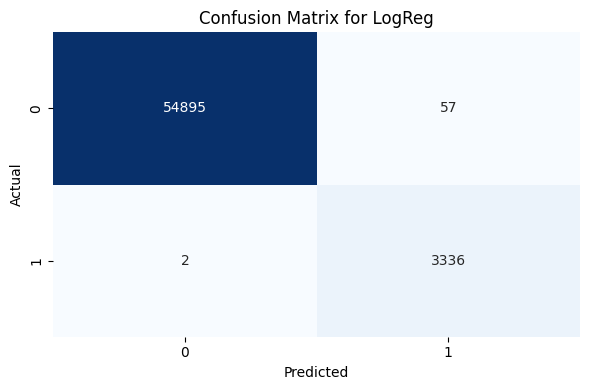

Training Models:  25%|██▌       | 1/4 [00:08<00:24,  8.30s/it]


Model SVC-RBF saved as SVC-RBF_model.pkl

Results for SVC-RBF on hold-out set:
 Accuracy  : 0.998
 Precision : 0.971
 Recall    : 1.0
 F1-Score  : 0.985
 ROC AUC   : 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54952
           1       0.97      1.00      0.99      3338

    accuracy                           1.00     58290
   macro avg       0.99      1.00      0.99     58290
weighted avg       1.00      1.00      1.00     58290



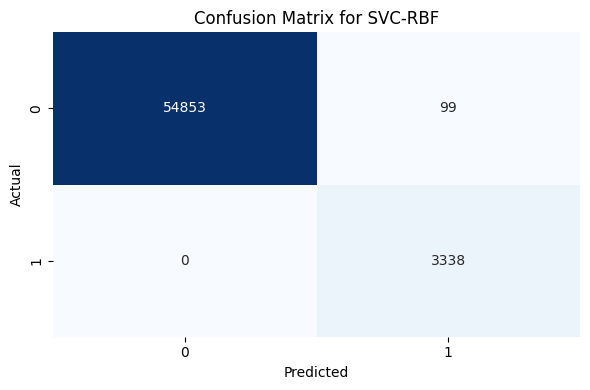

Training Models:  50%|█████     | 2/4 [04:44<05:31, 165.61s/it]


Model KNN saved as KNN_model.pkl

Results for KNN on hold-out set:
 Accuracy  : 0.999
 Precision : 0.976
 Recall    : 0.999
 F1-Score  : 0.988
 ROC AUC   : 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54952
           1       0.98      1.00      0.99      3338

    accuracy                           1.00     58290
   macro avg       0.99      1.00      0.99     58290
weighted avg       1.00      1.00      1.00     58290



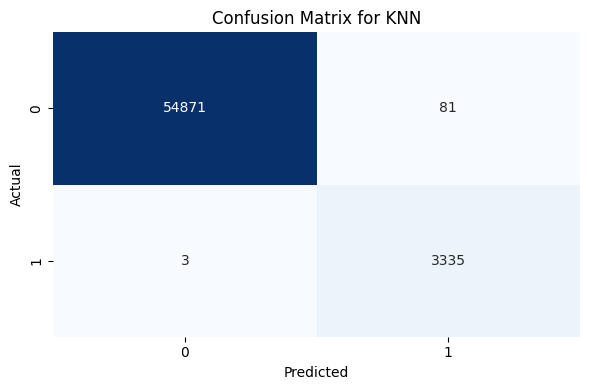

Training Models:  75%|███████▌  | 3/4 [05:58<02:03, 123.92s/it]


Model RF saved as RF_model.pkl

Results for RF on hold-out set:
 Accuracy  : 1.0
 Precision : 1.0
 Recall    : 1.0
 F1-Score  : 1.0
 ROC AUC   : 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     54952
           1       1.00      1.00      1.00      3338

    accuracy                           1.00     58290
   macro avg       1.00      1.00      1.00     58290
weighted avg       1.00      1.00      1.00     58290



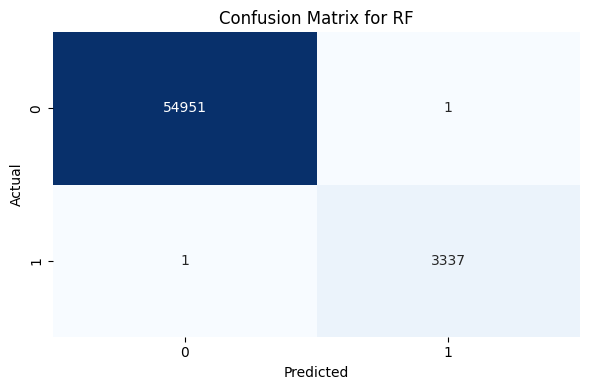

Training Models: 100%|██████████| 4/4 [06:40<00:00, 100.19s/it]


In [14]:
print("\n" + "─"*60 + "\nTraining and Evaluating Individual Models\n" + "─"*60)
for name, model in tqdm(models.items(), desc="Training Models"):
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
    
    # Lưu mô hình
    joblib.dump(model, f"{name}_model.pkl")
    print(f"\nModel {name} saved as {name}_model.pkl")
    
    # Dự đoán trên tập test
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # In các chỉ số đánh giá
    print(f"\nResults for {name} on hold-out set:")
    print(" Accuracy  :", accuracy_score(y_test, y_pred).round(3))
    print(" Precision :", precision_score(y_test, y_pred).round(3))
    print(" Recall    :", recall_score(y_test, y_pred).round(3))
    print(" F1-Score  :", f1_score(y_test, y_pred).round(3))
    if y_prob is not None:
        print(" ROC AUC   :", roc_auc_score(y_test, y_prob).round(3))
    
    # In classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Vẽ và in confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

In [15]:
best_name = results.iloc[0]["Model"]
best_model = models[best_name]
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n" + "─"*60 + "\nBest model on hold-out set:", best_name)
print(" Acc :", accuracy_score(y_test, y_pred).round(3))
print(" Prec:", precision_score(y_test, y_pred).round(3))
print(" Rec :", recall_score(y_test, y_pred).round(3))
print(" F1  :", f1_score(y_test, y_pred).round(3))
print(" ROC :", roc_auc_score(y_test, y_prob).round(3))


────────────────────────────────────────────────────────────
Best model on hold-out set: RF
 Acc : 1.0
 Prec: 1.0
 Rec : 1.0
 F1  : 1.0
 ROC : 1.0


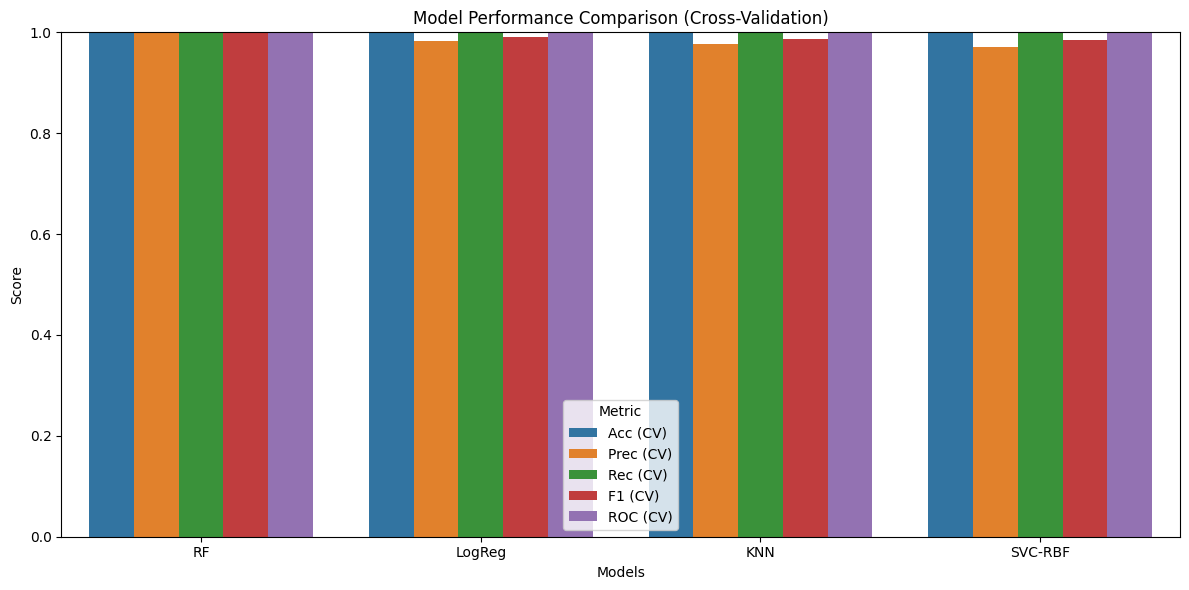

In [16]:
# Cell 7: Vẽ biểu đồ so sánh mô hình
results_melted = results.melt(id_vars="Model", 
                              value_vars=["Acc (CV)", "Prec (CV)", "Rec (CV)", "F1 (CV)", "ROC (CV)"],
                              var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=results_melted, x="Model", y="Score", hue="Metric")
plt.title("Model Performance Comparison (Cross-Validation)")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("Models")
plt.legend(title="Metric")
plt.tight_layout()
plt.show()